In [4]:
import numpy as np

# cache matrix-nullSpaceSolution to avoid recomputation
matrix_nullSpaceSolution = {}

def findNullSpace(A):
    # flatten tupple A
    B=  A.flatten()
    if tuple(B) in matrix_nullSpaceSolution:
        return matrix_nullSpaceSolution[tuple(B)]
    # Compute the SVD of A
    U, S, Vt = np.linalg.svd(A)

    # Find the null space of A
    null_space = Vt.T[:, S.size:]

    # Choose a non-trivial vector from the null space
    non_trivial_solution = null_space[:, 0]
    # Cache the result
    matrix_nullSpaceSolution[tuple(B)] = non_trivial_solution
    return non_trivial_solution
    # return Vt[-1]




def caratheodory(P, w):
    assert len(P) == len(w)
    n, d = P.shape
    if n <= d + 1:
        return P, w
    weigtedSumOfPoints = np.dot(w, P)
    # Compute the matrix M (each column is pi - p1)
    M = (P[1:] - P[0]).T  # shape (d, n-1)
    v= findNullSpace(M)   
    v1 = -np.sum(v)
    v = np.insert(v, 0, v1)

    alpha = np.inf
    for i in range(n):
        if v[i] > 0:
            alpha = min(alpha, w[i] / v[i])
    u = w - alpha * v
    assert np.all(u >= -0.0000001)
    S = P[u > 0]
    u = u[u > 0]
    weightedSumOfPoints2 = np.dot(u, S)
    assert np.allclose(weigtedSumOfPoints, weightedSumOfPoints2)
    if len(S) > d + 1:
        return caratheodory(S, u)  # Recursive call if needed
    return S, u


# write the function for k-streaming algorithm based caraheodory algorithm (take d+2 points and keep reducing the points)
import numpy as np

def streaming_caratheodory(P, w, d):

    n = len(P)
    selected_points = P[:d+1]
    selected_weights = w[:d+1]
    
    for i in range(d+1, n):

        selected_points = np.vstack((selected_points, P[i]))
        selected_weights = np.append(selected_weights, w[i])
        
        # Apply Caratheodory's theorem to reduce the set to d+1 points
        selected_points, selected_weights = caratheodory(np.array(selected_points), np.array(selected_weights))
    
    return selected_points, selected_weights

In [5]:
def transformMatrix(A):
    return np.vstack([np.outer(r, r).flatten() for r in A])



In [7]:
d=3
import tqdm as tqdm
import numpy as np
import random as rd
Id=np.eye(d)

def A_matrix(n):
    A= np.random.randint(1, 10, size=(n, d))
    # add a random nmumber column to A
    A=np.hstack((A, np.random.randint(1, 10, size=(n, 1))))
    # add Id to A

    Id= np.identity(d)
    # add zero values to the last column of Id
    Id=np.hstack((Id, np.zeros((d, 1))))
    
    A=np.vstack((A, Id))
    # convert A to int


    return A    

def count_rows_with_one_nonzero(matrix):
    count = 0
    for row in matrix:
        if np.count_nonzero(row) == 1:
            count += 1
    return count

K=300
lambdas={}
d1=[9999999 for i in range(K)]
d2=[9999999 for i in range(K)]
# log number of regularized points for each value of lambda= c^2/4 for each value of k in a dictionary
noRegularizedPoints={}
# use tqdm to show progress bar

for k in tqdm.tqdm(range(K)):
    C=A_matrix(k)

    # assign equal weights to all points
    weigts=np.ones(k+d)
    # normalize the weights
    weigts=weigts/np.sum(weigts)
    #  experiment with different values of c to see how the caratheodory representation changes
    for c in range(1,2000):
        # multiply the last 3 rows of B by c

        B=C.copy()
        B[-d:]*=c/2
        # transform B to get the caratheodory representation
        D=transformMatrix(B)
        # remove zero rows
        D=D[:,~np.all(D == 0, axis=0)]
        # print(D)

        weigtedSum=np.sum(D*weigts[:,None],axis=0)

        S,u = streaming_caratheodory(D, weigts,d=len(D[0]))
        # print(S)
        # break

        sum_rows=np.sum(S!=1,axis=1)
        lambda1=(c**2)/4
        if (k,lambda1) not in noRegularizedPoints:
            noRegularizedPoints[(k,lambda1)]=[]
        noRegularizedPoints[(k,lambda1)].append(count_rows_with_one_nonzero(S))


        weigtedSum2=np.sum(S*u[:,None],axis=0)

        assert np.allclose(weigtedSum, weigtedSum2)
        if count_rows_with_one_nonzero(S)==1:
            d1[k-3]=min(d1[k-3],(c**2)/4)
        if count_rows_with_one_nonzero(S)==2:
            d2[k-3]=min(d2[k-3],(c**2)/4)
        
        if count_rows_with_one_nonzero(S)==d:
            lambdas[k]=(c**2)/4
            # print(k,c)
            break




 


100%|██████████| 300/300 [02:12<00:00,  2.26it/s]


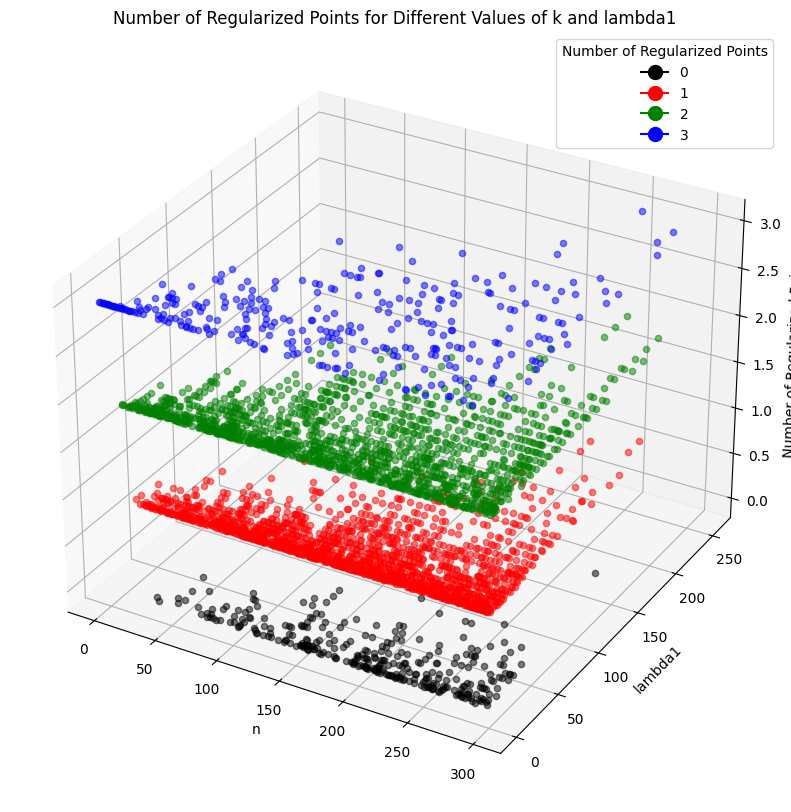

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Convert the noRegularizedPoints dictionary to separate lists
k_values = []
lambda1_values = []
counts = []

for (k, lambda1), count_list in noRegularizedPoints.items():
    k_values.extend([k] * len(count_list))
    lambda1_values.extend([lambda1] * len(count_list))
    counts.extend(count_list)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Define color categories based on the number of regularized points
colors = np.array(['k','r', 'g', 'b'])
categories = [0,1, 2, 3]
color_map = dict(zip(categories, colors))

# Plot the scatter points with different colors
for count, k, lambda1 in zip(counts, k_values, lambda1_values):
    color = color_map.get(count, 'k')  # Default color is black
    ax.scatter(k, lambda1, count, color=color, alpha=0.5)

# Set labels and title
ax.set_xlabel('n')
ax.set_ylabel('lambda1')
ax.set_zlabel('Number of Regularized Points')
ax.set_title('Number of Regularized Points for Different Values of k and lambda1')

# Add a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=f'{category}',
                              markerfacecolor=color, markersize=10) for category, color in color_map.items()]
ax.legend(handles=legend_elements, loc='upper right', title='Number of Regularized Points')

plt.show()

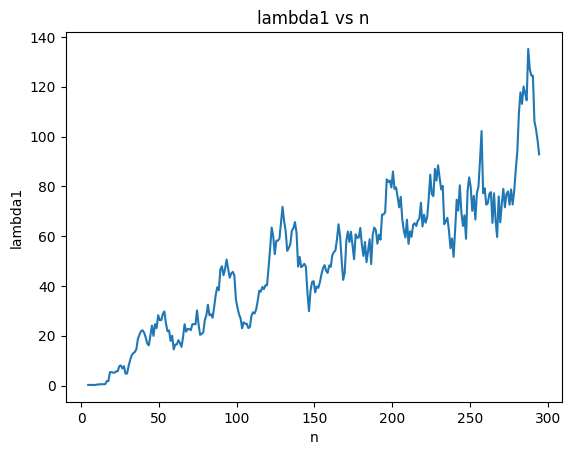

In [39]:
# graph of lambda1 vs n after smoothigh


# plt.plot(list(lambdas.keys()), list(lambdas.values()))
x=list(lambdas.keys())
y=list(lambdas.values())
# smoothuing the graph by taking the mooving average
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

x = moving_average(x, 10)
y = moving_average(y, 10)
plt.plot(x, y)




plt.xlabel('n')
plt.ylabel('lambda1')
plt.title('lambda1 vs n')
plt.show()


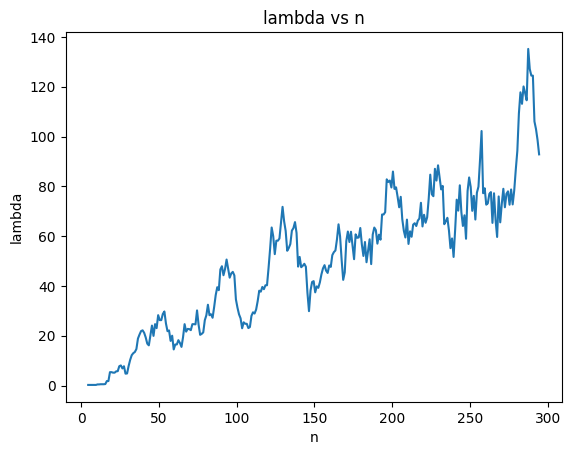

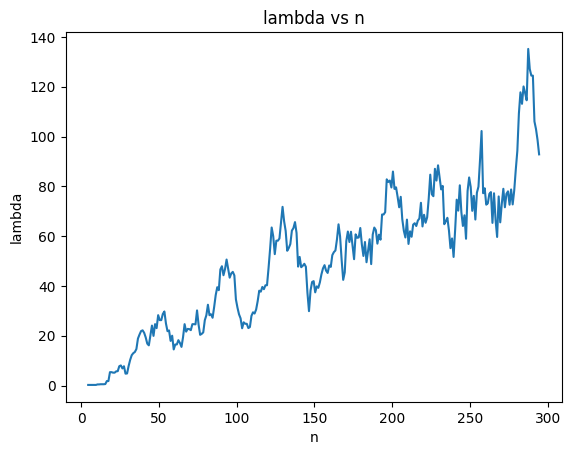

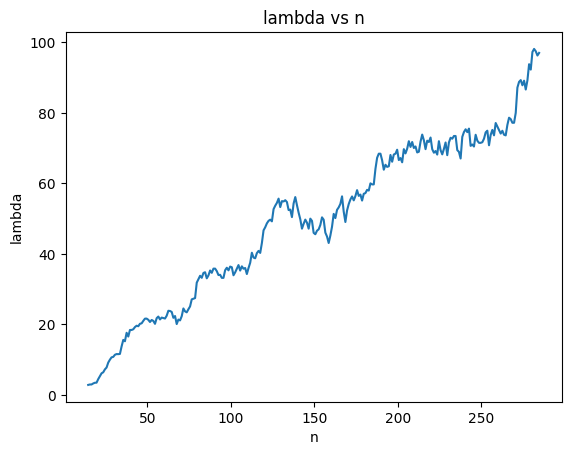

In [13]:
import matplotlib.pyplot as plt

# k=list(range(K))
# plt.plot(k,d1)
# plt.xlabel("k")
# plt.ylabel("lambda")
# plt.title("d1 vs k")

# plt.show()
# # d2.reverse()
# k=list(range(K))
# plt.plot(k,d2 )
# plt.xlabel("k")
# plt.ylabel("lambda")
# plt.title("d2 vs k")
# plt.show()
import numpy as np
import matplotlib.pyplot as plt


k = list(lambdas.keys())
v = list(lambdas.values())

# Smoothing function
def moving_average(data, window_size):
    weights = np.repeat(1.0, window_size) / window_size
    return np.convolve(data, weights, 'valid')

window_size = 10
smK = moving_average(k, window_size)
smV = moving_average(v, window_size)

# Plot
plt.plot(smK, smV)
plt.xlabel("n")
plt.ylabel("lambda")
plt.title("lambda vs n")
plt.show()
# Smoothen k and v
window_size = 10
smK = moving_average(k, window_size)
smV = moving_average(v, window_size)

# Plot
plt.plot(smK, smV)
plt.xlabel("n")
plt.ylabel("lambda")
plt.title("lambda vs n")
plt.show()

window_size = 30
smK = moving_average(k, window_size)
smV = moving_average(v, window_size)

# Plot
plt.plot(smK, smV)
plt.xlabel("n")
plt.ylabel("lambda")
plt.title("lambda vs n")
plt.show()
# graph d2 and k to see how d2 changes with k
# k=list(range(200,2,-1))
# plt.plot(k,d2)
# plt.xlabel("k")
# plt.ylabel("lambda")

# plt.title("d2 vs k")

# plt.show()



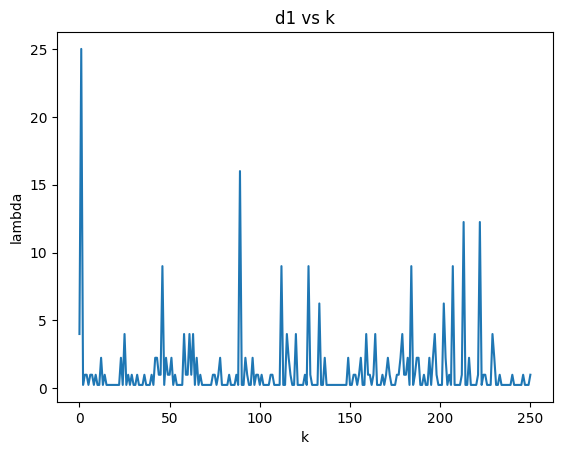

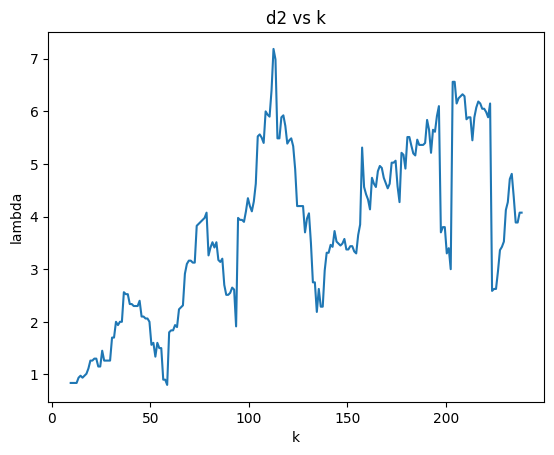

In [12]:
d1
# remove all 9999999 from d1
d1=[x for x in d1 if x!=9999999]
# graph d1
k=list(range(len(d1)))
# smoothen the graph
# window_size = 20
smK = moving_average(k, window_size)
plt.plot(k,d1)
plt.xlabel("k")
plt.ylabel("lambda")
plt.title("d1 vs k")

plt.show()
d2

# remove all 9999999 from d2
d2=[x for x in d2 if x!=9999999]
# graph d2
k=list(range(len(d2)))

# smoothen the graph
window_size = 20
smK = moving_average(k, window_size)
smV = moving_average(d2, window_size)
# Plot
plt.plot(smK, smV)
plt.xlabel("k")
plt.ylabel("lambda")


plt.title("d2 vs k")

plt.show()
